# 다중선형회귀(Multiple Linear Regression)

복습
* 회귀모델을 만들 때 기준모델을 어떻게 정의하나? 이 과정이 왜 중요할까?

- [How to Calculate R Squared Using Regression Analysis](https://youtu.be/w2FKXOa0HGA)
    - $R^2$ 값이 1에 가깝다는 것은 무엇을 의미하나?

- [Standard Error of the Estimate used in Regression Analysis (Mean Square Error)
](https://youtu.be/r-txC-dpI-E)
    
- [Training and testing](https://youtu.be/P2NqrFp8usY)
    - 왜 훈련/테스트 데이터를 나누는 것일까?

- [Machine Learning Fundamentals: Bias and Variance](https://youtu.be/EuBBz3bI-aA)
    - low bias, low variance 모델은 어떤 모델을 말하나?


#### 그래픽 라이브러리

* Plotly : ["Getting Started with Plotly in Python"](https://plot.ly/python/getting-started/#jupyterlab-support-python-35)

## 데이터를 학습/테스트 데이터로 나누어 보자

In [1]:
import pandas as pd
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/house-prices/house_prices_train.csv')

In [2]:
## 컬럼명을 살펴보자
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

이 데이터를 가지고 몇가지 회귀 모델을 만들어 보고, 모델의 성능을 평가하기 위해 훈련/테스트 데이터로 나누어 보자.

- 우리가 정말 관심있는것은 모델 학습에 사용한 **훈련(train) 데이터를 잘 맞추는 모델이 아니라, 학습에 사용하지 않은 테스트(test) 데이터를 얼마나 잘 맞추는지**  이다.

- 데이터를 훈련/테스트 데이터로 나누어야 우리가 **만든 모델의 예측 성능을 제대로 평가**할 수 있다.

다시 강조하자면 **학습에 사용하는 데이터와 모델을 평가하는데 사용하는 데이터가 달라야 한다**는 의미이다.

**그렇다면 데이터를 어떻게 나누어야 할까?**

> 데이터를 무작위로 선택해 나누는 방법이 일반적이지만, 시계열 데이터를 가지고 과거에서 미래를 예측하려고 하는 경우 무작위로 데이터를 섞으면 절대로 안될것이다. 이때는 훈련 데이터 보다 테스트 데이터가 미래의 것이어야 할 것.

**무작위로 훈련/테스트 데이터셋**으로 나누어 보면

In [3]:
## 데이터의 75% 갯수
len(df)*0.75

1095.0

In [4]:
## train/test 데이터를 sample 메소드를 사용해 나눔
train = df.sample(frac=0.75,random_state=1)
test = df.drop(train.index)

In [5]:
## head
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
258,259,60,RL,80.0,12435,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,231500
267,268,75,RL,60.0,8400,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,179500
288,289,20,RL,NaN,9819,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,122000
649,650,180,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2007,WD,Normal,84500
1233,1234,20,RL,NaN,12160,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,5,2010,COD,Abnorml,142000


In [6]:
## train, test 길이 비교
len(train), len(test)

(1095, 365)

## 다중선형회귀모델을 학습

### 기준모델

우선 **타겟인 SalePrice의 평균**을 기준모델로 사용

In [7]:
# SalePrice 평균
train['SalePrice'].mean()

180327.24200913243

In [8]:
# label 정의
target = 'SalePrice'
y_train = train[target]
y_test = test[target]

In [9]:
# SalePrice 평균값으로 예측(기준모델)
predict = y_train.mean()

In [10]:
predict

180327.24200913243

In [11]:
# 기준모델로 훈련 에러(MAE) 계산
from sklearn.metrics import mean_absolute_error
y_pred = [predict] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)

print(f'훈련 에러: {mae:.2f}')

훈련 에러: 57775.57


In [12]:
# 테스트 에러(MAE)
y_pred = [predict] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:.2f}')

테스트 에러: 55862.90


### scikit-learn을 사용해서 단순선형회귀모델을 만들어 보자

먼저 GrLivArea (지상생활면적, sqft)와 SalePrice를 사용, scatterplot을 그리고 OLS 라인을 그려보자

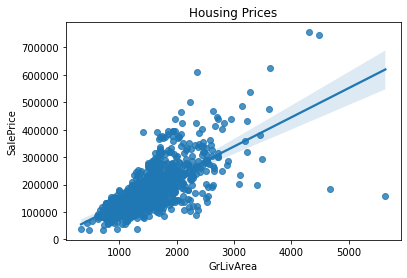

In [13]:
import seaborn as sns
sns.regplot(x=train['GrLivArea'], y=train['SalePrice']).set_title('Housing Prices');

이번에는 sklearn으로 단순선형회귀모델을 학습해보자

In [14]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

features = ['GrLivArea']
X_train = train[features]
X_test = test[features]

# 모델 fit
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'훈련 에러: {mae:.2f}')

훈련 에러: 38327.78


In [15]:
# 테스트 데이터에 적용
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:.2f}')

테스트 에러: 35476.63


**기준모델과 비교해 보면 에러가 줄어든 것을 확인할 수 있다.**

### 다중선형회귀모델 학습 (특성 2개 이상)

우선 OverallQual 특성을 추가하여 그래프를 확인해 보자

<ipython-input-16-68d1654976a5>:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


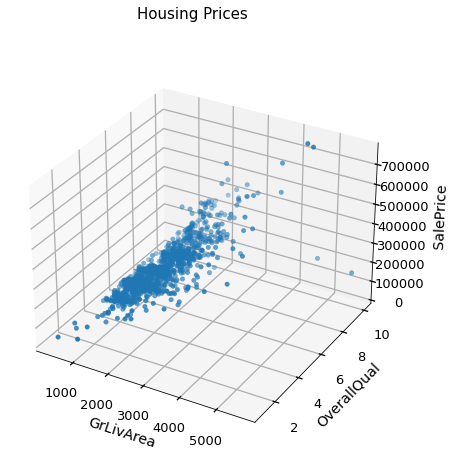

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style

style.use('seaborn-talk')
fig = plt.figure()

# for 3d plot
ax = fig.gca(projection='3d')

ax.scatter(train['GrLivArea'], train['OverallQual'], train['SalePrice'])
ax.set_xlabel('GrLivArea', labelpad=12)
ax.set_ylabel('OverallQual', labelpad=10)
ax.set_zlabel('SalePrice', labelpad=20)

plt.suptitle('Housing Prices', fontsize=15)
plt.show()

# (참고) plotly를 사용해서 상대적으로 간단히 그래프를 그릴 수도 있다.
# px.scatter_3d(
#     train,
#     x='GrLivArea', 
#     y='OverallQual', 
#     z='SalePrice',  
#     title='House Prices'
# )

scikit-learn을 사용해서 다중선형회귀 모델을 만들어 보자.

In [17]:
# 다중모델 학습을 위한 특성
features = ['GrLivArea', 
            'OverallQual']
X_train = train[features]
X_test = test[features]

In [18]:
# 모델 fit
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'훈련 에러: {mae:.2f}')

훈련 에러: 29129.58


In [19]:
# 테스트 데이터에 적용해 보자 
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:.2f}')

테스트 에러: 27598.31


하나의 특성을 사용한 단순선형회귀모델보다 테스트 오류가 더 줄어든 것을 확인할 수 있다. 

#### 단순선형회귀 모델과 비교하면

단순선형회귀에서는 모델이 직선의 방정식으로 표현이 되었다면, 이번에는 특성이 두 개이므로 평면의 방정식으로 표현이 된다.

Plotly를 사용하여 3D 평면을 표현해 보자.

In [20]:
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import itertools

def surface_3d(df, f1, f2, target, length=20, **kwargs):
    """
    2특성 1타겟 선형모델평면을 시각화
    
    df : 데이터프레임
    f1 : 특성 1 열 이름
    f2 : 특성 2 열 이름
    target : 타겟 열 이름
    length : 각 특성의 관측치 갯수
    
    """
    
    # scatter plot(https://plotly.com/python-api-reference/generated/plotly.express.scatter_3d)
    plot = px.scatter_3d(df, x=f1, y=f2, z=target, opacity=0.5, **kwargs)
    
    # 다중선형회귀방정식 학습
    model = LinearRegression()
    model.fit(df[[f1, f2]], df[target])    

    # 좌표축 설정
    x_axis = np.linspace(df[f1].min(), df[f1].max(), length)
    y_axis = np.linspace(df[f2].min(), df[f2].max(), length)
    coords = list(itertools.product(x_axis, y_axis))
    
    # 예측
    pred = model.predict(coords)
    z_axis = pred.reshape(length, length).T
    
    # plot 예측평면
    plot.add_trace(go.Surface(x=x_axis, y=y_axis, z=z_axis, colorscale='Viridis'))
    
    return plot

In [21]:
surface_3d(
    train,
    f1='GrLivArea', 
    f2='OverallQual', 
    target='SalePrice',  
    title='House Prices'
)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



## 회귀계수를 해석해 보고 모델을 평가해 보자

- 단순선형회귀식은 다음과 같았다: 
$y = \beta_0 + \beta_1 x $

- 지금 다룬 2특성의 다중선형회귀 식은 다음과 같다: 
$y = \beta_0 + \beta_1x_1 + \beta_2x_2$

- 계수들(coefficients or parameters) $\beta_0$~$\beta_2$ 는 어떻게 구할까? 

In [22]:
## 절편(intercept)과 계수들(coefficients)
model.intercept_, model.coef_

(-102743.02342270731, array([   54.40145532, 33059.44199506]))

In [23]:
## 회귀식을 만들어 보자.
b0 = model.intercept_
b1, b2 = model.coef_

print(f'y = {b0:.0f} + {b1:.0f}x\u2081 + {b2:.0f}x\u2082')

y = -102743 + 54x₁ + 33059x₂


$\beta_1$과 $\beta_2$ 모두 양수다. 이것은 $x_1$, $x_2$이 증가할 때마다 $y$ 도 증가한다는 뜻이다.
만약 음수인 경우에는 $y$ 가 감소한다는 뜻.

한 번 가상의 관측 데이터를 넣어보고 모델이 어떻게 예측하는지 보자.

In [24]:
model.predict([[2000, 10]])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



array([336654.30716253])

In [25]:
model.predict([[2000, 3]])

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:420: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



array([105238.21319714])

선형회귀는 다른 ML 모델에 비해 상대적으로 학습이 빠르고 설명력이 강하다. 하지만 선형 모델의 이므로 과소적합(underfitting)이 잘 일어난다는 단점이 있다. 과소적합에 대해서는 뒷 부분에서 편향과 분산에 대해서 다룰 때 자세히 알아보겠다.

### 회귀모델을 평가하는 평가지표들(evaluation metrics)

만들어진 회귀모델을 평가하는데는 다음과 같은 평가지표들이 있다.

* MSE (Mean Squared Error) = 
$\frac{1}{n}\sum_{i=1}^{n}(y_{i} - \hat{y_{i}})^{2}$
* MAE (Mean absolute error) = $\frac{1}{n}\sum_{i=1}^{n}\left | y_{i} - \hat{y_{i}} \right |$
* RMSE (Root Mean Squared Error) = 
$\sqrt{MSE}$
* R-squared (Coefficient of determination) = 
$1 - \frac{\sum_{i=1}^{n}(y_{i} - \hat{y_{i}})^{2}}{\sum_{i=1}^{n}(y_{i} - \bar{y_{i}})^{2}} = 1 - \frac{SSE}{SST} = \frac {SSR}{SST}$

- 참고
    - SSE(Sum of Squares `Error`, 관측치와 예측치 차이): $\sum_{i=1}^{n}(y_{i} - \hat{y_{i}})^{2}$
    - SSR(Sum of Squares due to `Regression`, 예측치와 평균 차이): $\sum_{i=1}^{n}(\hat{y_{i}} - \bar{y_{i}})^{2}$
    - SST(Sum of Squares `Total`, 관측치와 평균 차이): $\sum_{i=1}^{n}(y_{i} - \bar{y_{i}})^{2}$ , SSE + SSR


각 평가지표의 차이를 살펴보기 위하여 간단한 데이터를 만들어 보자.

In [26]:
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

df_study = pd.DataFrame([[1, 2, 3], [2, 1, 3], [3, 3, 6], [4, 5, 9], [4, 4, 8], [5, 5, 10], [7, 7, 14], [9, 8, 17], [10, 9, 19], [10, 10, 20]])
df_study.columns = ['Q1','Q2','Total']

In [27]:
df_study

,Q1,Q2,Total
0,1,2,3
1,2,1,3
2,3,3,6
3,4,5,9
4,4,4,8
5,5,5,10
6,7,7,14
7,9,8,17
8,10,9,19
9,10,10,20


In [28]:
from IPython.display import display
from matplotlib.patches import Rectangle

def evaluation_metrics(df, feature, target, slope, intercept):
    """
    2d 선형회귀직선과 제곱오차(squared errors)를 확인하기 위한 함수
    df : Pandas 데이터프레임
    feature : 특징 열
    target : 타겟 열
    slope : 선형방정식의 기울기
    intercept : 선형방정식의 y 절편
    """
    
    x = df[feature]
    y = df[target]
    
    # plot 데이터
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # 예측
    y_pred = slope * x + intercept
    
    # plot 예측
    ax.plot(x, y_pred)
    
    # Plot 제곱오차(MSE)
    x_left, x_right = ax.get_xlim() # x-axis view limits
    y_bottom, y_top = ax.get_ylim()
    scale = (x_right - x_left) / (y_top - y_bottom)

    for f, t, p in zip(x, y, y_pred):
        xy = (f, min(t, p))
        h = abs(t - p)
        w_scaled = h * scale
        ax.add_patch(Rectangle(xy=xy, width=w_scaled, height=h, alpha=0.2))
    
    # 회귀방정식 평가지표
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y, y_pred)

    display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,35.690000
1,MAE,5.280000
2,RMSE,5.974111
3,R2,0.000000


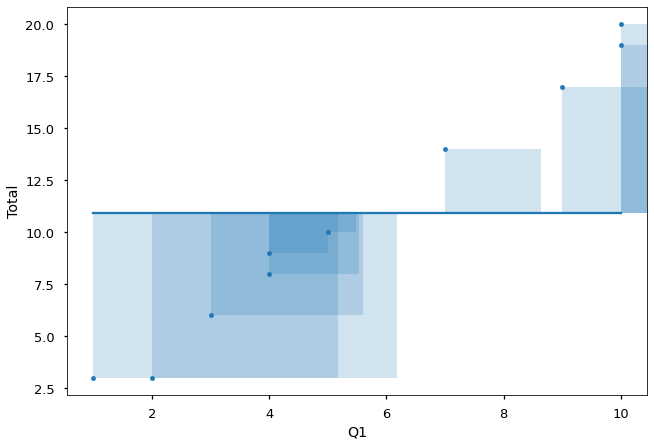

In [29]:
evaluation_metrics(df_study, 'Q1', 'Total', 0, df_study['Total'].mean())

Total 값의 평균을 회귀직선 으로 설정해 보자. $R^2$ 최소 값인 0 이 된다. 이 직선은 데이터를 전혀 설명하지 못하고 있음.

$R^2$ 값이 1에 가까울 수록 데이터를 잘 설명하는 모델이 된다. 기울기와 절편를 수동적으로 조절하는 과정에서 $R^2$ 값이 음수가 나올 수도 있지만 이렇게 적합이 되면 안됨.

이번에는 기울기를 조금 올려 보고 y절편도 조정해 보자. 에러가 많이 줄어드는 것을 볼 수 있다. $R^2$ 점수도 많이 올라 갔음

,Metric,Score
0,MSE,8.400000
1,MAE,2.400000
2,RMSE,2.898275
3,R2,0.764640


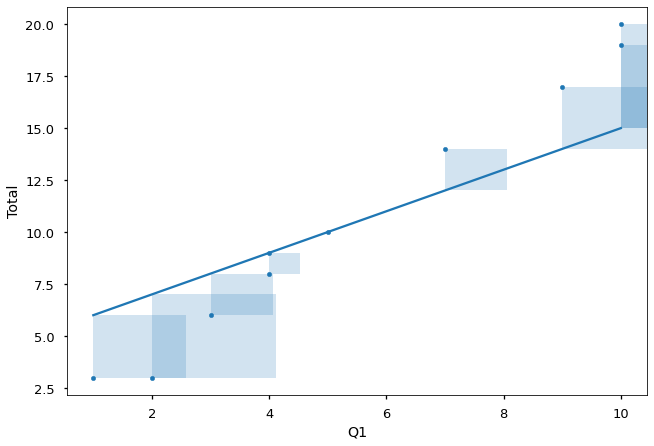

In [30]:
evaluation_metrics(df_study, 'Q1', 'Total', 1, 5)

조금 더 파라미터를 조정해 보자. 오차가 더 적어지고 $R^2$ 는 1에 매우 가까워 졌다.

,Metric,Score
0,MSE,0.500000
1,MAE,0.500000
2,RMSE,0.707107
3,R2,0.985990


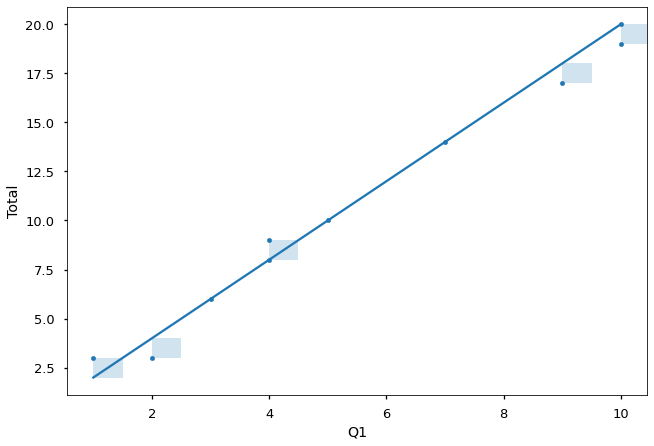

In [31]:
evaluation_metrics(df_study, 'Q1', 'Total', 2, 0)

$R^2$ 외에, MAE는 단위 유닛이 같으므로 보다 해석에 용이한 장점이 있고, MSE는 제곱을 하기 때문에 특이값에 보다 민감하다. RMSE는 MSE를 실제값과 유사한 단위로 변화시켜주는 장점이 있다.
- [회귀의 오류지표 알아보기](https://partrita.github.io/posts/regression-error/)

In [32]:
import plotly.express as px
px.scatter(
    df_study,
    x='Q1',
    y='Total',
    trendline='ols'
)

## 과적합(Overfitting)과 과소적합(Underfitting)
**일반화(generalization)**

- 테스트데이터에서 만들어내는 오차를 **일반화** 오차라고 부른다.
- 훈련데이터에서와같이 테스트데이터에서도 좋은 성능을 내는 모델은 **일반화가 잘 된 모델**이라고 부른다.
- 모델이 너무 훈련데이터에 과하게 학습(과적합)을 하지 않도록 하는 많은 **일반화 방법**들이 있다.

우리는 당연히 예측모델이 훈련데이터에서보다 테스트데이터에서 오차가 적게 나오기를 기대한다. 하지만 현실적으로 모든 데이터를 얻을 수 없기 때문에 훈련데이터로부터 일반화가 잘 되는 모델을 학습시켜야 한다.

- **과적합**은 모델이 훈련데이터에만 특수한 성질을 과하게 학습해 일반화를 못해 결국 테스트데이터에서 오차가 커지는 현상을 말한다
- 반대로 **과소적합**은 훈련데이터에 과적합도 못하고 일반화 성질도 학습하지 못해, 훈련/테스트 데이터 모두에서 오차가 크게 나오는 경우를 말한다.

사실 머신러닝과정 중에서 과적합은 피할 수 없는 문제이고 완전히 극복할 수도 없다. 그래서 대부분 학습알고리즘은 이런 과적합을 완화시킬 수 있는 방법을 제공하기 때문에 잘 알아 두어야 한다.

### 분산/편향 트레이드오프
과/소적합은 오차의 편향(Bias)과 분산(Variance)개념과 관계가 있다.

결론만 우선 정리해 보면

- **분산이 높은**경우는, 모델이 학습 데이터의 노이즈에 민감하게 적합하여 테스트데이터에서 일반화를 잘 못하는 경우 즉 **과적합** 상태이다.

- **편향이 높은**경우는, 모델이 학습 데이터에서, 특성과 타겟 변수의 관계를 잘 파악하지 못해 **과소적합** 상태이다.

#### 조금 더 자세하게 편향과 분산에 대한 식을 살펴보면,

MSE 식을 reducible, irreducible 에러로 나누어 표현하면 결국 Bias 에러 + Variance + irre 로 나뉘게 된다.([Bias–variance tradeoff
](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff))

${\displaystyle \operatorname {E} _{D}{\Big [}{\big (}y-{\hat {f}}(x;D){\big )}^{2}{\Big ]}={\Big (}\operatorname {Bias} _{D}{\big [}{\hat {f}}(x;D){\big ]}{\Big )}^{2}+\operatorname {Var} _{D}{\big [}{\hat {f}}(x;D){\big ]}+\sigma ^{2}}$

${\displaystyle \operatorname {Bias} _{D}{\big [}{\hat {f}}(x;D){\big ]}=\operatorname {E} _{D}{\big [}{\hat {f}}(x;D){\big ]}-f(x)}$

${\displaystyle \operatorname {Var} _{D}{\big [}{\hat {f}}(x;D){\big ]}=\operatorname {E} _{D}[{\big (}\operatorname {E} _{D}[{\hat {f}}(x;D)]-{\hat {f}}(x;D){\big )}^{2}]}$



#### 예를 들어보면. 독립변수와 종속변수가 비선형관계인 모델로 학습을 해야 하는 데이터에서,

1) **단순선형모델로 학습**하는 경우와

2) 데이터 포인트를 모두 지나가도록 곡선 피팅이 가능한 **다항모델로 학습**을 진행한다고 가정해 보자.

선형모델 예측은 학습데이터에서 타겟값과 오차가 크다. 이를 **"편향이 높다"**고 한다.(과소적합)

하지만 훈련/테스트 두 데이터에서 그 오차가 비슷하다 이를 **"분산이 낮다"**고 한다. (오차는 여전히 많지만)

<img src="https://i.imgur.com/MMgbCfP.png" width="600"/>

<img src="https://i.imgur.com/ZuQBBBt.png" width="600"/>

곡선을 피팅한 모델에서는, 학습데이터에서 오차가 0에 가까우나(**"낮은 편향"**), 테스트 데이터에서 오차가 많아진다.

이렇게 한 데이터세트에서는 오차가 적은데 다른 데이터 세트에서는 오차가 많이 늘어나는 현상
(데이터 세트의 종류에 따라 예측값 분산이 높을 때)을 **과적합**이라고 하며 **"분산이 높다"**라고 한다.

<img src="https://miro.medium.com/max/1400/1*_7OPgojau8hkiPUiHoGK_w.png" width="600" />

<img src="https://i.imgur.com/r1kNImu.png" width="450" />

- [The Dangers of Under-fitting and Over-fitting](https://medium.com/analytics-vidhya/the-dangers-of-under-fitting-and-over-fitting-495f9efa1847)

만들기 어렵지만, 편향도 적고 분산도 적은 모델이 좋은 모델이다.

우리가 어떤 모델을 학습시키든 훈련/테스트 데이터에서의 모델의 성능과 그 차이를 보고 과적합과 과소적합을 적절하게 구분해 낼 수 있는 것이 중요하다.

추가적으로 몇가지 다른 그림을 더 살펴 보자.
다음 그림은 높은 편향을 가지는 모델(과소적합), 높은 분산을 가지는 모델(과적합)을 비교하고 있다.

[Python Data Science Handbook,_ Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#The-Bias-variance-trade-off).

>![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-bias-variance-2.png)


> <img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png"/>

모델의 복잡성에 따라 성능 그래프를 그려 보면, 모델이 복잡해질 수록 훈련데이터 성능은 계속 증가하는데 검증데이터 성능은 어느정도 증가하다가 증가세가 멈추고 오히려 낮아지는 지점을 찾을 수 있다. 우리는 보통 이 시점을 과적합이 일어나는 시점으로 파악하고 더 복잡한 모델은 불필요함을 알게 된다.

### 다항회귀모델을 사용해서 과적합을 만들어 보자.
마지막으로, 독립변수와 타겟변수 사이에 비선형 관계를 학습할 수 있는 다항회귀모델(polynomial regression)의 차수(degrees)를 조정해 회귀곡선을 만들어보는 실험을 해보자.

In [33]:
# 실험에 사용할 랜덤 데이터를 만든다 (30, 2)
rng = np.random.RandomState(1)
data = np.dot(rng.rand(2, 2), rng.randn(2, 30)).T
X = pd.DataFrame([i[0] for i in data])
y = pd.DataFrame([i[1] for i in data])

이번에는 훈련, 테스트셋을 scikit-learn을 사용해 나누어 보자. [train/test split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [34]:
from sklearn.model_selection import train_test_split

## X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [35]:
from sklearn.preprocessing import PolynomialFeatures
X1 = np.arange(6).reshape(3, 2)
print(X1)

poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X1)

# poly = PolynomialFeatures(interaction_only=True)
# poly.fit_transforim(X)


[[0 1]
 [2 3]
 [4 5]]


Sklearn의 **PolynomialFeatures**는 다항회귀모델을 쉽게 구현하도록 도와준다.
이름에서 알 수 있듯이 다항 특성(polynomial features)을 방정식에 추가하는 것이다. 다항 특성은 특성들의 상호작용을 보여줄 수 있기 때문에 상호작용특성(interaction features)라고도 부른다.

예를들어 $x_1$, $x_2$ 두 특성을 가진 데이터가 입력으로 들어오면 이것을 기준으로 degree=2 인 새로운 특성을 만들어 내는데 즉 특성이 다음과 같이 변한다.
($x_1$, $x_2$) -> (1, $x_1$, $x_2$, $x_1^2$, $x_1x_2$, $x_2^2$)

degree = 3 인 경우는 특성이 더 많아짐


In [36]:
## X_poly: [1, a, b, a^2, ab, b^2]
X_poly

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

모델의 복잡도를 계속 올려 보자
- [Hyperparameters and Model Validation](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn)

Degree=1


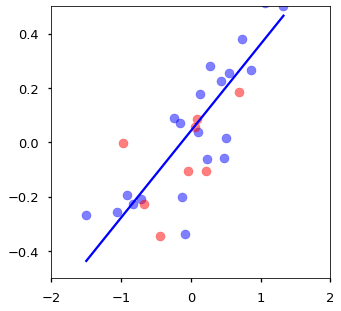

Degree=3


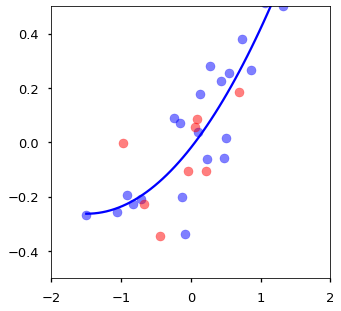

Degree=4


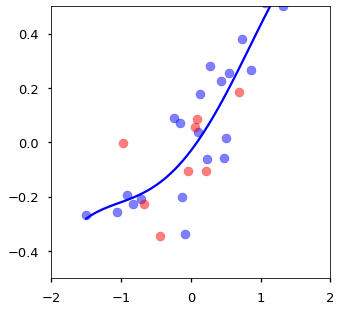

Degree=6


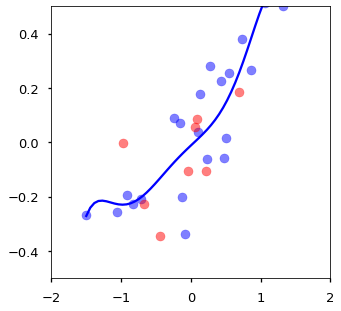

Degree=10


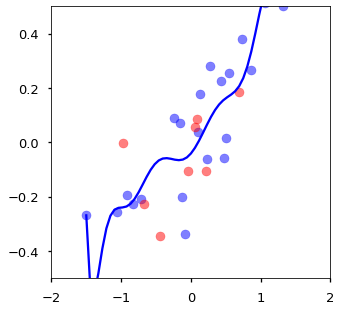

Degree=20


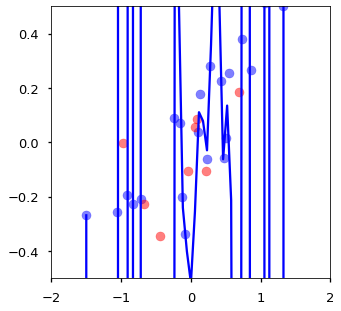

In [37]:
from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5,5)

# 다항회귀모델도 결국 다중선형회귀모델로 변형하여 모델을 만들 수 있는 선형모델.
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         LinearRegression(**kwargs))


polynomial_degrees = [1, 3, 4, 6, 10, 20]
train_r2s = []
test_r2s = []

for degree in polynomial_degrees:
    model = PolynomialRegression(degree)
    print(f'Degree={degree}')
    
    model.fit(X_train, y_train)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    display(HTML(f'<b style="color: blue">train R2 {train_r2:.2f}</b>'))
    display(HTML(f'<b style="color: red">test R2 {test_r2:.2f}</b>'))

    plt.scatter(X_train, y_train, color='blue', alpha=0.5)
    plt.scatter(X_test, y_test, color='red', alpha=0.5)
    

    x_domain = np.linspace(X.min(), X.max())
    curve = model.predict(x_domain)
    plt.plot(x_domain, curve, color='blue')
    plt.axis([-2., 2.0, -0.5, 0.5])
    plt.show()
    display(HTML('<hr/>'))
    
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)

모델 복잡도가(차수) 올라갈 수록 과적합 되어 훈련 $R^2$ 값이 좋아지지만 테스트 $R^2$ 값은 줄어드는 것을 확인 할 수 있다.

## 참고자료

#### plotly
- [plotly API reference](https://plotly.github.io/plotly.py-docs/index.html)

#### 훈련/테스트 세트 분리
- [Forecasting,Chapter 3.4](https://otexts.com/fpp2/accuracy.html)
- [How (and why) to create a good validation set](https://www.fast.ai/2017/11/13/validation-sets/)

#### Bias-Variance Tradeoff

- [Bias/Variance](https://youtu.be/SjQyLhQIXSM)
- [Machine Learning Fundamentals: Bias and Variance](https://youtu.be/EuBBz3bI-aA)
- [The Bias-Variance Tradeoff](https://towardsdatascience.com/the-bias-variance-tradeoff-8818f41e39e9)
- [Python Data Science Handbook,Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#The-Bias-variance-trade-off)

#### Regression
- [5 step process](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Basics-of-the-API)
- [Scikit-Learn LinearRegression documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- [Sum of Squares](https://corporatefinanceinstitute.com/resources/knowledge/other/sum-of-squares/)
- [$R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination)
- [상관계수 & 결정계수](https://m.blog.naver.com/istech7/50153288534)
- [회귀의 오류지표 알아보기](https://partrita.github.io/posts/regression-error/)

# Exercise

# 다중선형회귀(Multiple Linear Regression)

In [38]:
import pandas as pd
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/kc_house_data/kc_house_data.csv')

In [39]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

## 1) 데이터는 May 2014 ~ May 2015 의 2년치 데이터이다. 2015-01-01 부터 큰 날짜의 데이터는 테스트, 그 이외의 데이터는 훈련 데이터셋으로 나누어라.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [41]:
df['date'] = pd.to_datetime(df['date'])

train = df[df['date'].dt.strftime('%Y') == '2014']
test = df[df['date'].dt.strftime('%Y') == '2015']

train.shape

(14633, 21)

## 2) 두 특성(bathrooms, sqft_living)을 사용해서 다중선형회귀 모델을 만들어 보라
- 학습시 Parameters는 모두 기본값으로 한다.
- 정규화(normalize) 등 추가적인 데이터처리 없이 진행한다.

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
model = LinearRegression()

features = ['bathrooms', 
            'sqft_living']
X_train = train[features]
X_test = test[features]

target = 'price'
y_train = train[target]
y_test = test[target]

In [43]:
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'훈련 에러: {mae:.2f}')

훈련 에러: 170777.34


In [44]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:.2f}')

테스트 에러: 179252.53


## 3) 모델의 회귀계수(coefficients)와 절편(intercept)을 확인해보라.

In [45]:
model.intercept_, model.coef_

(-50243.56279640319, array([-5158.92591411,   286.13753555]))

In [46]:
b1, b2 = model.coef_

# 절편
b0 = model.intercept_ 

print("y = " + str(b1) + "x1 + " + str(b2) + "x2 - "+ str(abs(b0)))

y = -5158.925914109244x1 + 286.1375355497683x2 - 50243.56279640319


## 4) MSE, RMSE, MAE, $R^2$ 를 훈련/테스트 데이터에 대해 확인해보라.

In [47]:
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [48]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [49]:
mse, mae, rmse, r2

(71083994178.75656,
 179252.52593261772,
 266615.81757044455,
 0.45999300199894533)

## 5)  EDA를 진행하시고, 두개 이상의 특성을 선택하여 특성공학(feature engineering)을 진행한 후 아래의 질문들에 대해 논해 보라. 

- 어떤 이유에서 해당 특성공학을 진행했나? 특성공학을 통해 기대하는 효과는 무엇이었나? 만약 얻고자 하는 효과를 얻지 못했다면 이유는 무엇이며 어떤 액션을 추가할 수 있을까? 
- 특성공학을 거친 특성을 포함해 다수의 특성을 사용한 모델을 학습하고 테스트 데이터에 대해 MSE, RMSE, MAE, R2 스코어는 어떠한가? 해당 결과를 통해 얻을 수 있는 인사이트는 어떤 것이 있었나? 
- 만들어진 회귀계수를 사용해 모델을 설명해 본다면? 
- 만들어진 모델은 과소적합인가? 과대적합인가? 일반화가 잘 된 모델을 만들기 위해 추가로 할 수 있는 액션은 어떤 것이 있을까? 


# Column definitions

id - Unique ID for each home sold

date - Date of the home sale

price - Price of each home sold

bedrooms - Number of bedrooms

bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but 
no shower

sqft_living - Square footage of the apartments interior living space

sqft_lot - Square footage of the land space

floors - Number of floors

waterfront - A dummy variable for whether the apartment was overlooking the 
waterfront or not

view - An index from 0 to 4 of how good the view of the property was

condition - An index from 1 to 5 on the condition of the apartment,

grade - An index from 1 to 13, where 1-3 falls short of building construction 
and design, 7 has an average level of construction and design, and 11-13 have a 
high quality level of construction and design.

sqft_above - The square footage of the interior housing space that is above 
ground level

sqft_basement - The square footage of the interior housing space that is below 
ground level

yr_built - The year the house was initially built

yr_renovated - The year of the house’s last renovation

zipcode - What zipcode area the house is in

lat - Lattitude

long - Longitude

sqft_living15 - The square footage of interior housing living space for the 
nearest 15 neighbors

sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

----- 

-일반적인 집값 데이터가 그렇듯, 오른쪽으로 꼬리가 매우 긴 skewed 데이터입니다.

* 여러 특성들에서 이상치로 보이는 데이터들이 많은데, 예를 들면 방이 33개라든가, 바다가 보이는 주택이라든가, 이런 것들은
분석의 목적과 필요에 따라 제거하든가, 이상치도 하나의 성질이니 포함하든가 등 선택하여 분석합니다.

<br>

* 선형회귀분석을 사용하는 가장 큰 이유는 '남에게 설명하기 쉬워서' 라고 생각합니다.
<br>

* 분석의 방향은 분석의 목적에 따라 조금 달라지게 됩니다.
<br>

* 주택 가격을 설명하는데 ~~ 변수의 조합이 유의미함을 밝히고 싶다 하면 필요한 변수만 넣어서 하면 되고, 최대한 정확하게 가격을 예측하는 모델을 만들어야 한다면(사실 이러면 선형회귀를 안쓰지만) 가정들을 만족한다는 전제 하에 가능한 많은 변수를 투입하는게 좋을것이라고 생각합니다.
<br>

* 피쳐엔지니어링을 해볼만한 데이터는 방과 화장실의 갯수를 더한 피쳐를 만든다 or 공간의 특성을 가지고 있는 피쳐를 더해서 새로운걸 만들어본다 or 재건축을 한 집은 건축연도를 해당 연도로 갱신하여 새로운 건축연도 피쳐를 만든다 등이 있을 수 있습니다.
<br>

* 기준모델을 소수의 변수로 잡아 세우셨다면, 좋은 추가 특성을 변수로 추가했을 시 R^2 점수는 오를 것입니다.
<br>

* 만약 기준모델을 모든 변수를 다 집어넣은 회귀모델로 정했다면, 해당 변수들이 선형성을 만족한다는 전제 하에 R^2 점수는 많은 경우 기준모델이 제일 높게 나올 것입니다. 회귀분석의 특성상 변수가 많을수록 설명하는데 유리하기 때문입니다. 따라서 이런 경우 adjusted R^2 를 대신 사용하는데 저는 그럼에도 불구하고 모든 변수를 다 집어넣은 모델의 adj R^2 값이 제일 높게 나왔습니다.
<br>

* 그렇다고 해서 다른 사람에게 설명해야 할 때 zipcode, latitude, longitude 등 애매한 변수까지 포함된 모델을 가지고 설명하면 이해가 어려울 수도 있으니 이것이 좋은 모델이라고 하기는 조금 애매합니다.
<br>

- 건축 연도에 대한 데이터만 처리했을 때 그냥 R^2 값은 before: 0.680 after: 0.672가 나왔습니다. 큰 차이는 없어보입니다.
<br>

* 이 모델로 집값 데이터의 67.2%를 설명할 수 있습니다.
<br>

* 모델을 일반화하여 성능을 향상 시키기 위해서는 다음과 같은 방법을 사용할 수 있습니다.

1. 정규화 선형회귀 - 릿지회귀, 라쏘회귀, 엘라스틱넷
2. 일반화 선형회귀(GLM)
3. 변수변환(회귀분석의 기본 가정을 만족하지 못할 경우)

  * 로그변환, 제곱근변환, 지수변환, 제곱변환, box-cox변환
  * 입력자료가 범주형 변수인 경우 각 범주값이 하나의 변수를 나타내는 형태로 
 더미변수를 생성(One-hot encoding)
 
* 선형회귀를 버린다

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

In [52]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [53]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

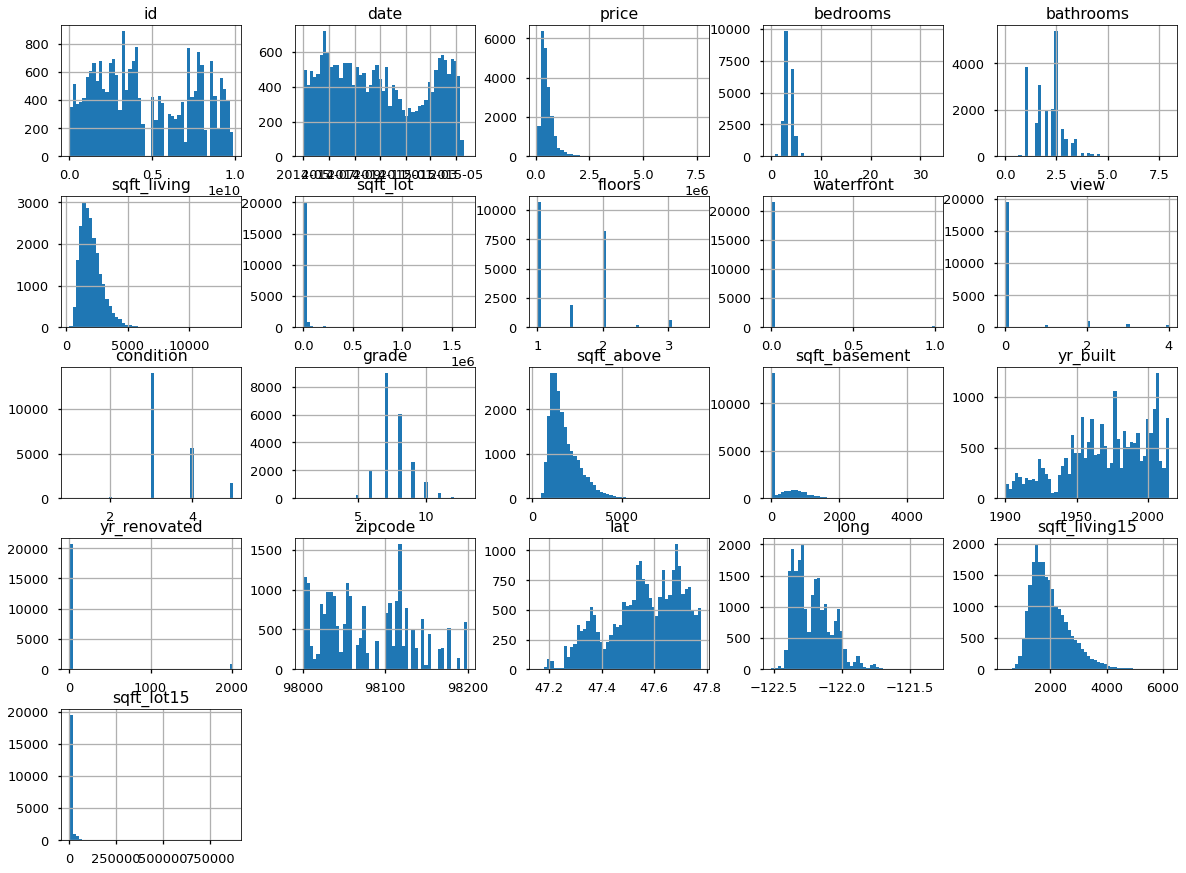

In [54]:
df.hist(bins=50, figsize=(20,15));

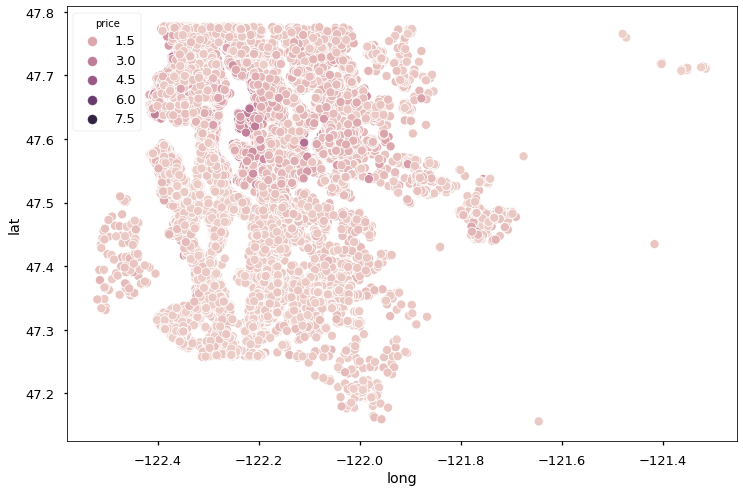

In [55]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='long', y='lat',data=df,hue='price');

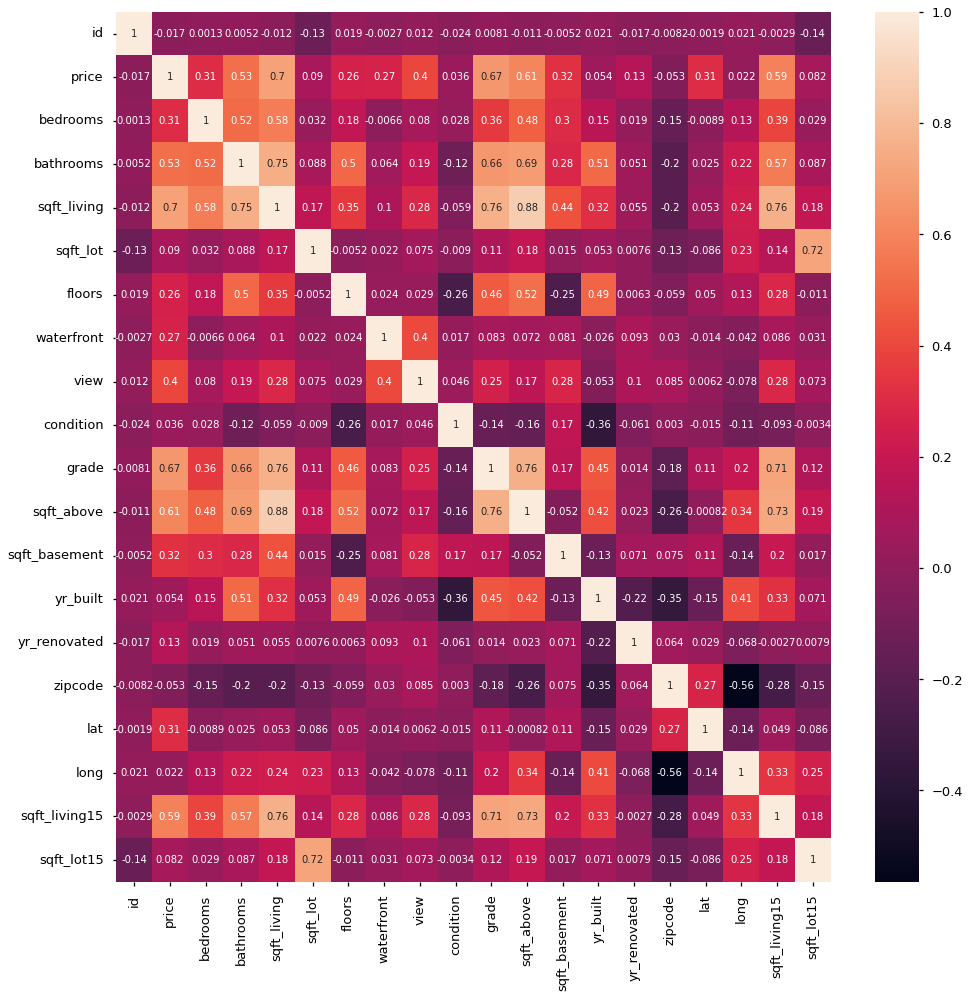

In [56]:
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(), annot=True);

In [57]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


<AxesSubplot:xlabel='price', ylabel='Count'>

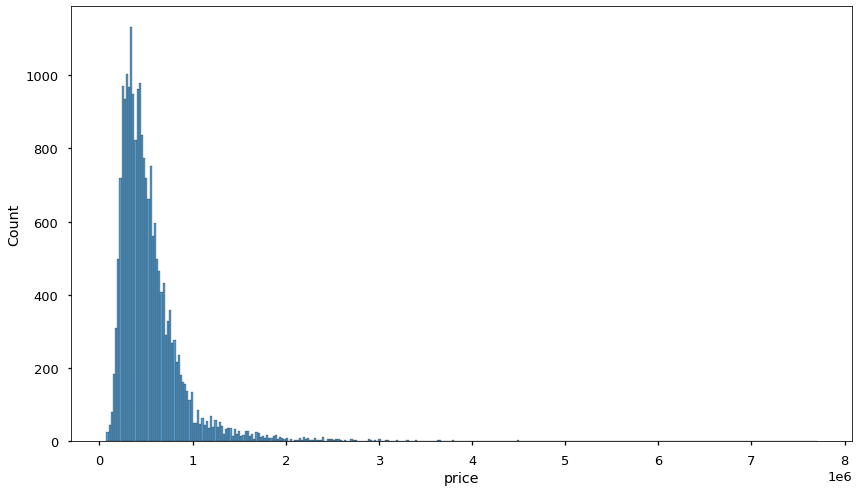

In [58]:
plt.figure(figsize=(14,8))
sns.histplot(df['price'])

In [59]:
df['bedrooms'].value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [60]:
df['bathrooms'].value_counts()

2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [61]:
df['floors'].value_counts()

1.0    10680
2.0     8241
1.5     1910
3.0      613
2.5      161
3.5        8
Name: floors, dtype: int64

In [62]:
df['waterfront'].value_counts()

0    21450
1      163
Name: waterfront, dtype: int64

In [63]:
df['view'].value_counts()

0    19489
2      963
3      510
1      332
4      319
Name: view, dtype: int64

In [64]:
df['condition'].value_counts()

3    14031
4     5679
5     1701
2      172
1       30
Name: condition, dtype: int64

In [65]:
df['grade'].value_counts()

7     8981
8     6068
9     2615
6     2038
10    1134
11     399
5      242
12      90
4       29
13      13
3        3
1        1
Name: grade, dtype: int64

In [66]:
df['sqft_basement'].value_counts()

0      13126
600      221
700      218
500      214
800      206
       ...  
518        1
374        1
784        1
906        1
248        1
Name: sqft_basement, Length: 306, dtype: int64

In [67]:
df['yr_renovated'].value_counts()

0       20699
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

In [68]:
features = ['bedrooms',	'bathrooms',	'sqft_living',	'sqft_lot',	'floors',	'waterfront',	'view',	
            'condition',	'grade',	'sqft_above',	'sqft_basement',	'yr_built',	'yr_renovated',
            'zipcode',	'lat',	'long',	'sqft_living15',	'sqft_lot15']
X_train = train[features]
X_test = test[features]

target = 'price'
y_train = train[target]
y_test = test[target]

In [69]:
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'훈련 에러: {mae:.2f}')

훈련 에러: 123577.70


In [70]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:.2f}')

테스트 에러: 130720.09


In [71]:
model.intercept_, model.coef_

(8239666.947421931,
 array([-3.57100818e+04,  3.99410718e+04,  1.15843037e+02,  1.00320595e-02,
         5.85649785e+03,  5.98770279e+05,  5.31566509e+04,  2.73608117e+04,
         9.46582543e+04,  7.75883778e+01,  3.82546599e+01, -2.59950946e+03,
         2.27063698e+01, -5.73343598e+02,  5.86573437e+05, -2.00733732e+05,
         1.02438295e+01, -3.46717793e-01]))

In [72]:
print('R^2 Variance score  {0:.3F}\n'.format(r2_score(y_test, y_pred)))

R^2 Variance score  0.680



In [73]:
X = X_train
y = y_train

In [74]:
# adjusted R-squared
1 - ( 1-model.score(X, y) ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 )

0.7068457054148348

In [75]:
df.drop(['id'], axis=1, inplace=True)

In [76]:
df['year'] = 0
df['year'][1]

0

In [77]:
for i in range(len(df)):
  if df['yr_renovated'][i] == 0:
    df['year'][i] = df['yr_built'][i]
  else:
    df['year'][i] = df['yr_renovated'][i]

<ipython-input-77-37fdf43739e6>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-77-37fdf43739e6>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [78]:
df['year']

0        1955
1        1991
2        1933
3        1965
4        1987
         ... 
21608    2009
21609    2014
21610    2009
21611    2004
21612    2008
Name: year, Length: 21613, dtype: int64

In [79]:
df['date'] = pd.to_datetime(df['date'])
train = df[df['date'].dt.strftime('%Y') == '2014']
test = df[df['date'].dt.strftime('%Y') == '2015']

In [80]:
features = ['bedrooms',	'bathrooms',	'sqft_living',	'sqft_lot',	'floors',	'waterfront',	'view',	
            'condition',	'grade',	'sqft_above',	'sqft_basement',	'year',
            'zipcode',	'lat',	'long',	'sqft_living15',	'sqft_lot15']
X_train = train[features]
X_test = test[features]
target = 'price'
y_train = train[target]
y_test = test[target]

In [81]:
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

In [82]:
y_pred = model.predict(X_test)

In [83]:
print('R^2 Variance score  {0:.3F}\n'.format(r2_score(y_test, y_pred)))

R^2 Variance score  0.672



In [84]:
X = X_train
y = y_train

In [85]:
# adjusted R-squared
1 - ( 1-model.score(X, y) ) * ( len(y) - 1 ) / ( len(y) - X.shape[1] - 1 )

0.6953853673090888

## 참고자료
* [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)
* ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)
* [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf)
* [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
* [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)